<a href="https://colab.research.google.com/github/potohodnica/magistrska/blob/main/MNIST_PyTorch_for_Beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/amsharma7/mnist-pytorch-for-beginners-detailed-desc


# MNIST using PyTorch for Beginners (Detailed Descriptions)
### PyTorch

PyTorch is a famous python framework for deep learning. It's gaining interest in the deep learning community because of its syntactical similarities with python and operational similarities with numpy - which is the fundamental package for scientific and mathematical computing in Python.
Deep Learning

Deep Leaarning is a subset of Machine Learning (Shallow Learning) that, generally, requires huge amount of data in order to puke out good results. However, this statement isn't enitrely true as we will soon see, in this notebook itself, that having huge datasets isn't always a necessary criteria to apply deep learning solutions to specific problems.
What is a Deep Learnig solution anyway?

To keep things simple, just remember the following equation

Deep Learning = Neural Networks with more than 3 layers
Neural Networks

Neural Network is, usually, a supervised method of learning. By supervised I mean, we know the target variable and its values for particular records and hence we can feed in this data to machine learning and deep learning algorithms and specify what it needs to learn. In contrast, the unsupervised learning methods require algorithms to just 'figure out' what are the relations between the records in the data that is fed into them.

Following 'layers' consists of a Neural Network

    Input Layer
    Hidden Layers
    Output Layer

Every network has 1 input and 1 Output layer but can have any number of hidden layers, so in order to implement deep learning, we need at least 2 hidden layers in out network.

Details about a Neural Network, their different types and architecture is an active research topic and are already well defined and explained in numerous blogs and videos around the internet. Following are few links that I found relatively easy to understand:

    3b1b's neural net video: https://www.youtube.com/watch?v=aircAruvnKk&t=9s
    Medium neural net blog: https://towardsdatascience.com/first-neural-network-for-beginners-explained-with-code-4cfd37e06eaf
    Neural Network's Chart: https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464

P.S. I really enjoyed the DeepLizard.com's course on PyTorch. They have really started from the very basic and have ended on a fairly complex note and the learning was so intuitive, probably because they have covered every minute detail that goes on in PyTorch as well as Neural Networks and even Python. Just leaving their course's link here for anyone to get started with... something!

Link: https://deeplizard.com/learn/video/v5cngxo4mIg



MNIST Dataset

We are using the most famous Dataset for Computer Vision provided by the Turing Award holder and a very prominent personality in deep learning community: Dr Yann LeCun.

The dataset consists of 28x28 pixel, greyscale images. The rest of the details are given clearly in the description of this dataset.
Implementation

We will be implementing a specific type of Neural Network called 'Convolutional Neural Network (CNN)' and we'll follow the following steps:

   1. Import the libraries
   2. Load the dataset
   3. Splitting features and target variables
   4. Split the data into train and test sets
   5. Rescaling Values
   6. Converting to torch tensors
   7. Dataset and DataLoader
   8. Define Neural Network Architecture Input Layer Convolution Layer Pooling Layer Activation Function Regularization Linear Layer
   9. Loss Function
   10. Optimiser
   11. Train the Neural Network
   12. Predict the labels on actual test data




1. Import the libraries

In [ ]:
#PyTorch Specific libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

#Data manipulation and visualisation specific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For splitting the data into Train and Test set
from sklearn.model_selection import train_test_split

# This piece of code is required to make use of the GPU instead of CPU for faster processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#If it prints "cuda:0" that means it has access to GPU. If it prints out "cpu", then it's still running on CPU.

cuda:0



2. Load the dataset

After loading the dataset with the help of panda's read_csv() function, we check if the data is imported correctly or not. This can be done in many ways, the simplest way is to check the number of rows and column. And we can do so with the help of shape attribute. It outputs in the format - (rows, columns).


In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/wehrley/Kaggle-Digit-Recognizer/master/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/wehrley/Kaggle-Digit-Recognizer/master/test.csv')

#Let's check if they have been loaded properly
print('train.shape:\n', train.shape)
print('test.shape:\n', test.shape)

train.shape:
 (42000, 785)
test.shape:
 (28000, 784)



3. Splitting features and target variables

The label is the last column and rest of the columns are all the features Here, X -> Features; y -> Labels

Why to name "X" and "y"? They are the standard names used by everyone. You could use anything instead of X and y but since it's used by almost everyone, so it makes your code more readable to others since they would instantly know what they are looking at and would then be able to debug your code fast, in case you need help.

In [ ]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1:] #Could have done like this 
y = train.label.values # but needed to convert it to np.ndarray for torch tensor conversion



Now, spliting with train.iloc[:,-1:] would have resulted the same as train.labels.values have. The only difference between the two is, the former would have resulted in a Series and the latter is preserved as ndarray - which is what we want since we would be convertiing this into a PyTorch Tensor in a while.


In [ ]:
print('X.shape: ', X.shape, 'X.type: ', type(X) )
print('y.shape: ', y.shape, 'y.type: ', type(y) )

X.shape:  (42000, 784) X.type:  <class 'pandas.core.frame.DataFrame'>
y.shape:  (42000,) y.type:  <class 'numpy.ndarray'>



4. Split the data into train and test sets

We need a test set, apart from the original test.csv that is provided, for the purpose of our training and validation. The test.csv doesn't contain the target variable and hence the model can't be trainied on that. The target (label column) is only present in train.csv. Hence, we will split the data in the training set (training.csv) into two parts - training set (for training the model) and test set (for validation). To do so, we will use train_test_split() method from sklearn.model_selection. This method takes in the features (X) and label column (y) separately in the first 2 parameters. The 3rd parameter is test_size, which we can set in order to specify with what percentage we want to split our data. We are going to use "0.1" as the argument value. This will split our data into 90% training and 10% test sets. The 4th parameter is the random_state. This is an optional parameter which you will find as a part of many ML algorithms. It is required to produce same results and eliminate any 'randomness' that the algorithms can take since a lot of the internal values in ML algorithms have to assume some random values as part of their execution.

The function outputs 4 values, essentially splitting the X and y in to 2 parts each (test and training sets)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.1, random_state = 1)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (37800, 784)
y_train.shape:  (37800,)
X_test.shape:  (4200, 784)
y_test.shape:  (4200,)



5. Rescaling values

The pixel values that we have got in the dataset is in the range of (0,255). For neural network (or any machine learning algorithm for that matter) to be efficient, we rescale the values to (0,1). That means, all the values will be between 0 and 1.


In [ ]:
#Rescaling values
X_train = X_train.values/255
X_test = X_test.values/255


6. Converting to torch tensors¶

PyTorch works with tensors. Tensors can be visualised as multidimensional arrays. Just like numpy arrays, or Tensorflow's tensors. PyTorch has its own form of arrays.

torch.from_numpy() function converts a numpy array or a panda's dataframe to torch tensor (remember why we needed 'y' to be a numpy array and not series?)


In [ ]:
#Converting to Tensors
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

print('X_train.dtype:', X_train.dtype)
print('X_test.dtype:', X_test.dtype)
print('y_train.dtype:', y_train.dtype)
print('y_test.dtype:', y_test.dtype)

X_train.dtype: torch.float64
X_test.dtype: torch.float64
y_train.dtype: torch.int64
y_test.dtype: torch.int64



7. Dataset and DataLoader

We use Data Loaders because sometimes the datasets can have upto millions of records which may eventually lead to enormous size of those datasets and hence they are generally very difficult to load in memoty all at once. Due to the limited available memory space, we use a technique called batching. Batching is simply accessing records from such huge datasets in batches and not all at once.

For example, Let's suppose you have 1000 records in a dataset and you want to apply batching on this dataset. So, if you set the batch size to 200, your model will first be trained on the first set of 200 records in 1 iteration of the feedforward network. Then, it will train on the next set of records and so on. So, it will essentially take 5 iterations for the whole dataset to be passed through the feed forward network.

Just to clear things:

batch: Small set of the larger dataset

iteration: 1 batch going from the input layer to the output layer is said to complete one iteration

epochs: When every record of the dataset is passed through the network, then the network is said to have finised 1 epoch

Now, the MNIST dataset isn't that large that we have to use dataloader, but since it's a general practice to load the data in batches, so, I am going to implement using dataloader.

Head to PyTorch's official documentation on Dataset class, DataLoader and Transforms to know more about the same: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Now we will make our dataset using TensorDataset class and would set the batch size to be 100.

Then with the help of DataLoader class, that will provide an iterable over our dataset, we will make our train_loader and test_loader. The shuffle paramtere is set to true in order to specify that the records in a particular batch needs to be randomly selected from the whole dataset and not select in their original sequence as they appear.


In [ ]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

batch = 100

# Set our data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size = batch, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch, shuffle = True)


8. Define neural network architecture

We will be defining the folllowing in the Net() class:

    - Input Layer
    - Convolution Layer
    - Pooling Layer
    - Activation Function
    - Regularization
    - Linear Layer

Here's a briefing of everything that's going on in the following cell.

Net() Class: Net() is the main class which inherits nn.Module class. Net() class has two methods, namely, __init__() and forward().

init() method: The __init__() method, which is one of the 'special methods' that are provided by python, stands for initialisation and as the name tells itself, it is used to initialise everything that we need to. It inherits all the properties of the nn.Module's own __init__ function when we write super().__init__(). All the convolution layers, pooling layers, dropout layers, Linear (Dense/fully connected) layers are defined in this method.

forward() method: It's the forward() method where we set the course of our network and use all the layers that we define in the __init__ method.

When we execute the code, the init method will be called and everything would be initialised. When we'll make the object of the same class, the forward method will be executed.

The architecture:

```
Layer 1: Convolution Layer 1 > Activation Function (RelU) > Pooling Layer 1 > Dropout Layer 1
Layer 2: Convolution Layer 2 > Activation Function (RelU) > Pooling Layer 2 > Dropout Layer 2
Flatten the output from the 2 layer
Layer 3: Linear Layer 1 > Activation Function (RelU) > Dropout Layer 3
Layer 4: Linear Layer 2 > Activation Function (RelU) > Dropout Layer 4
Layer 5: Output Layer > Activation function (softmax)
```




In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 128, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.3)
        
        self.conv2 = nn.Conv2d(128, 224, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(224*4*4, 64)
        self.drop3 = nn.Dropout(p=0.4)
        
        self.fc4 = nn.Linear(64, 32)
        self.drop4 = nn.Dropout(p=0.4)
        
        self.fc5 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim=1)
   
    
    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        
        x = x.view(-1,224*4*4)
        
        x = self.drop3(F.relu(self.fc3(x)))
        x = self.drop4(F.relu(self.fc4(x)))
        
        x = self.softmax(self.fc5(x))
        
        return x

print(Net()) 

Net(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(128, 224, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=3584, out_features=64, bias=True)
  (drop3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)




Q. Why these many layers? Why not less or more?

A. Choosing the number of layers is up to the network designer (you). It's with hit and trial that you develop an intiution of how many layers (or neurons) a particular problem may require to get to the desired solution. You can play with the number of layers and neurons (numbers like 128, 224 etc) and see how the network is responsding to your changes.

Q. What does Conv2d(1, 128, 5) actually mean?

A. Conv2d() is a function that helps create a convolution layer. The three paramteres mentioned (in order) are: input_channels, output_channels and kernel_size.

input_channels: input_channels refers to the number of channels the input has. If our dataset contained colored images, this argument would have been equal to 3. But our dataset contains only the black and white pictures (more generally called as the grayscale images), so a grayscale images have only 1 channel. Hence the argument is equal to 1.

output_channels: output_channels is arbitrary number and can be set to any number you want. It basically sets the number of neurons that its input_channels would be connected to. It also sets the input_channels of the next convolution layer. So, output_channel (previous layer) = input_channel (next layer)

kernel_size: kernel_size is a square matrix of a particular width and height. When we set the third parameter to 5, it basically means we are setting the square kernel of size 5 x 5. A kernel can be thought of as a window (matrix) that slides over our image to extract certain features out of it in order to learn. That's why kernels are also called as feature maps.

There's anther parameter that we haven't explicitly defined but by default is set to 1, and that is 'stride'. A stride means by how much the kernel should slide in order to output the next feature map. stride = 1 essentially means that it will slide by 1 pixel to right and 1 pixel to down.

Q. What is pooling?

A. Pooling is another type of layer in a neural network that down samples the feature maps created by the convolution layer. It basically summarises a portion of the image in a much lesser space. It is done to reduce variance and computations. But why Max-pooling? It's because max-pooling helps in extracting low-level features like edges, points, etc. There are other type of pooling methods such as average pooling and others.

Q. What is the importance of view() function in the forward() method?

A. The view() function takes in a tensor (for ex a 4D tensor) and outputs a lower dimensional tensor (for example a 1D tensor). This is required because the next set of layers are the linear layers. And linear layers only accept a 1D tensor (a "flattened" array) as an input. So, the view function is used to flatten the tensor so that it can then be fed to the linear layers.

Q. What is a Dropout Layer?

A. To help understand what dropout really is, we need to understand what regularisation in general is
Regularization

Regularization helps to solve over fitting problem in machine learning. It is nothing but adding a penalty term to the objective function and control the model complexity using that penalty term.

Too complex?

For now, consider it as something that tells our model to not cross a certain boundry (threshold). Because if it does, it will be overfitted. Overfiting is a problem that machine learning algortihms face when the model is 'too exact' to be used for actual real world data. That simply means that our model, when overfitted, wouldn't be accurate in preidction task when a new datapoint is fed into the model (for example a datapoint from the test dataset). So, in order to avoid overfitting, we use regularization. This is just an intuition. We don't need to get into the math of anything for now.

Dropout is one of the regularization methods. Dropout helps avoid overfitting by simply 'switching off' some of the neurons in a particular iteration. Sometimes, the outup of a particular neuron from a particular layer can shoot off to a high value or to a very low value. So, the dropout method helps the network to consider some of the other neurons that it might have been ignoring because of their lower valued outputs. So, by simply turning off some neurons, it makes sure that it takes into account every neuron and hence train in a more vigorous manner and hence avoid overfitting.

Q. What is RelU and softmax?

A. RelU is short for Rectified Linear Unit. RelU and Softmax are both activation functions. What are activation functions, you ask? Well, they can be thought of as something that restricts the values of the neurons after computations to explode to extremes (very high negative or very high positive) values. Activation functions makes sure the values are bounded within a range. For example, the relu function makes sure the values are between (0,max(val)) range, where 'val' is the actual value of the neuron.

Q. But why only relu and Softmax are chosen?

A. You can choose any activation function you want. However, recent researches proves that relu performs well in almost all the cases as comapred to other activation functions. tanh is another very commonly used activation function. We don't have the luxury of choosing just any activation function when it comes to the output layer. We want to choose an activation function according to our desired output. We have chosen softmax because softmax gives out a class score for every class which is basically a probablity distribution that in turn tells us how confident is the neural network about a certain class to be the actual output.

Note: The two modules imported from the torch library: nn and functional can be used interchangeable. Having said that, all the functions that are present in the nn module are there in the functional module as well. The only difference is the names of these funtions.

For example, Max pooling function from the functional module can be called as:

F.max_pool2d(x, kernel_size, stride)

and from the nn module:

nn.MaxPool2d(kernel_size, stride)

Why are there two implementations of the same things? It's to suit the coding style of different people. Some prefer a stateful approach while others prefer a more functional approach.

9. Loss function

A neural network 'learns' by adjusting various parameters through out the network. Weight is one of the paramter that the neural network learns to adjust. Weight is simply the strength of the two adjoining neurons that it is connected to and it is a numeric value. The new weight values are updated duriing backpropagation process. Now, the thing to note here is, how are these new values calculated?

The answer is: with the help of loss functions.

Loss functions are simply a method to calculate the prediction error of the network. Simply put, it tells the network which weight to be adjusted and how much it needs to be adjusted. Essentially, it calculates if a particular weight value needs to be decreased (subtracting from thhe original value) or increased (adding to the original value) and by how much.

There are many loss functions that can be used. The two most common ones are Cross Entropy Loss and NLL Loss for classification problems (just a reminder that we are dealing with a classification problem right now). The choice of which loss function to use is an experimental problem. You can follow this guide to start using the loss functions and by practice, build your own intiution.

For now, I'll be using the Cross Entropy Loss

We are now making an object of our Net() class and setting the loss function. We are using the Cross Entropy Loss. You can use any other loss function as well.


In [ ]:
#Making an object of the Net class
model = Net().to(device)

#Loss function
criterion = nn.CrossEntropyLoss ()


10. Optimizer

An optimizer ties the loss function and model parameters together by updating the model in response to the output of the loss criterion. We will be using Adam as our optimizer with a learning rate of 0.0015. Why 0.0015? Again, it's an experimental value. You need to hit and trial with all of these parameters that are changable. After a while dealiing with and constructing neural networks, you'll develop an intiution of which values could possibly work for a particular problem.


In [ ]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0015)


11. Train the Neural Network

Now it's finally time to train our network. We will be setting some variablbes first and then start training our network.


In [ ]:
# Initialising variables
epochs = 30
steps = 0
print_every = 100
trainLoss = [] 
testLoss = []

In [ ]:
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1   # Forward pass
        
        images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
        optimizer.zero_grad()
        log_ps = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = criterion(log_ps, labels)
        loss.backward()   # Backward pass
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
                    log_ps = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    test_loss += criterion(log_ps, labels)
                    ps = torch.exp(log_ps)
                    
                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            trainLoss.append(running_loss/len(train_loader))
            testLoss.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, epochs),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/30..  Test Accuracy: 0.716
Epoch: 1/30..  Test Accuracy: 0.772
Epoch: 1/30..  Test Accuracy: 0.854
Epoch: 2/30..  Test Accuracy: 0.860
Epoch: 2/30..  Test Accuracy: 0.950
Epoch: 2/30..  Test Accuracy: 0.960
Epoch: 2/30..  Test Accuracy: 0.963
Epoch: 3/30..  Test Accuracy: 0.968
Epoch: 3/30..  Test Accuracy: 0.966
Epoch: 3/30..  Test Accuracy: 0.971
Epoch: 3/30..  Test Accuracy: 0.969
Epoch: 4/30..  Test Accuracy: 0.970
Epoch: 4/30..  Test Accuracy: 0.967
Epoch: 4/30..  Test Accuracy: 0.968
Epoch: 4/30..  Test Accuracy: 0.967
Epoch: 5/30..  Test Accuracy: 0.975
Epoch: 5/30..  Test Accuracy: 0.972
Epoch: 5/30..  Test Accuracy: 0.976
Epoch: 6/30..  Test Accuracy: 0.969
Epoch: 6/30..  Test Accuracy: 0.971
Epoch: 6/30..  Test Accuracy: 0.975
Epoch: 6/30..  Test Accuracy: 0.973
Epoch: 7/30..  Test Accuracy: 0.976
Epoch: 7/30..  Test Accuracy: 0.970
Epoch: 7/30..  Test Accuracy: 0.973
Epoch: 7/30..  Test Accuracy: 0.974
Epoch: 8/30..  Test Accuracy: 0.975
Epoch: 8/30..  Test Accuracy



We are using a for loop to go through a total of 30 epochs.

The images tensor is a 2D tensor, we first convert it into a 4D tensor since our neural network (the Net() class) requires it to be a 4D tensor. Hence we use the view() function.

optimizer.zero_grad() sets all the gradient's values to zero. It's an essential step while training the network.

log_ps = model(images.type(torch.FloatTensor)) simply gives a set of images to the network for training. Here the set is of 100, as we set it earlier while defining the DataLoader

loss = criterion(log_ps, labels) compare the predicted and the actual labels and calculates the loss.

loss.backward() is the step where the network starts backpropagating in order to adjust the weights and other parameters of the network and start the training process all over again.

Please note that the loss is calculated by the loss function but the weights are updated only during backpropagation.

running_loss += loss.item() is used to calculate trainLoss which eventually would be helpful in plotting the graph of training and validation loss

Since we don't want every iteration to get printed on the screen, we only want every 100th iteration to get prinited with the accuracy score, hence we have used an if statment for the same.

with torch.no_grad(): the with keyword is an elegant way of handling exceptions in python. The wrapper torch.no_grad temporarily sets all the requires_grad flag to false. Eventually, it will reduce the memory usage and speed up computations.

model.eval() it indicates the model that nothing new is to be learnt and the model is used for testing.

torch.exp(log_ps) returns a new tensor with the exponential of the elements of the input tensor

ps.topk(1, dim = 1) returns a sparse copy of the tensor

labels.view(*top_class.shape) sees how many of the classes were correct?

torch.mean(equals.type(torch.FloatTensor)) calculate the mean (gets the accuracy for this batch) and add it to the running accuracy for this epoch

model.train() tells your model that you are training the model. So effectively, layers like dropout etc, which behave different on the train and test procedures, know what is going on and hence can behave accordingly.

Let's now visualise the training and validation loss


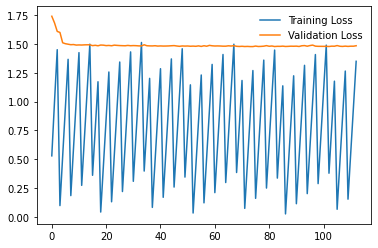

In [ ]:
%matplotlib inline
testLoss_list = []
for element in testLoss:
  testLoss_list.append(element.tolist())

plt.plot(trainLoss, label = 'Training Loss')
plt.plot(testLoss_list, label = 'Validation Loss')
plt.legend(frameon = False)


12. Predict the labels on actual test data

Now, we apply all the steps for the actual test data from the test.csv and finally make a 'submission.csv' with all out predictions.


In [ ]:
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

finalTest = test.values/255

finalTest = torch.from_numpy(finalTest)

temp = np.zeros(finalTest.shape)
temp = torch.from_numpy(temp)

data = torch.utils.data.TensorDataset(finalTest, temp)

submissionLoader = torch.utils.data.DataLoader(data, batch_size = batch, shuffle = False)

submission = [['ImageId', 'Label']]

with torch.no_grad():
    model.eval()
    image_id = 1
    for images, _ in submissionLoader:
        images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
        log_ps = model(images.type(torch.FloatTensor).to(device))
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1
            


pytorchSubmission = pd.DataFrame(submission)
pytorchSubmission.columns = pytorchSubmission.iloc[0]
pytorchSubmission = pytorchSubmission.drop(0, axis = 0)

pytorchSubmission.to_csv("submission.csv", index = False)